In [ ]:
#default_exp experimental.SMC.mixtures

This [paper](https://arxiv.org/abs/0710.4242v1) outlines an approach to constructing IS proposals from mixture models that can be adapted to well-match the target distribution (in terms of entropy).

In [ ]:
#export
import numpy
import scipy
from matplotlib import pyplot
from functools import partial
import seaborn
from sklearn.neighbors import KDTree
import jax.numpy as jnp
import jax.scipy as jsc
from tqdm import tqdm
from time import time
from amppl.utilities import progbar
from amppl.utilities import progbar
from jax import jit
from arviz import psislw
from amppl.experimental.SMC.proposals import BinaryGridSearch,BinaryGridSearchAtModesSingleProcess

from amppl.experimental.SMC.proposals import MixtureDistribution, KernelDefinition#, #FastMVNormal
from amppl.math import make_positive_semidef

In [ ]:
#export
fast_mv_normal=jit(jsc.stats.multivariate_normal.logpdf)
fast_normal=jit(jsc.stats.norm.logpdf)
fast_diag=jit(jnp.diag)

class FastMVNormal():
    def __init__(self, mean, cov=None,sd=None, diag=False):
        self.mean=mean
        if isinstance(cov, type(None))==False:
            self.cov=cov
            self.sd=fast_diag(self.cov)**.5
            self.diag=diag
        else:
            diag=True
            self.cov=None
            self.sd=sd
            self.diag=diag
    def logpdf(self, x):
        if self.diag==False:
            return fast_mv_normal(x, mean=self.mean, cov=self.cov)
        else:
            return jnp.sum(fast_normal(x, loc=self.mean, scale=self.sd), axis=1)
            
    def rvs(self, size):
        if self.diag==False:
            return scipy.stats.multivariate_normal.rvs(mean=self.mean,cov=self.cov, size=size)
        else:
            return scipy.stats.norm.rvs(loc=self.mean,scale=self.sd, size=(size, len(self.mean)))            


In [ ]:
import numpy as np
import sklearn
import math
from scipy.stats import chi2
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from random import *
from matplotlib.patches import Ellipse
from numpy.linalg import cholesky
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

In [ ]:
#export
def compute_importance_weights(logP,logQ):
    a=logP-logQ
    a=numpy.nan_to_num(a, numpy.nanmin(a))
    pi=a-scipy.special.logsumexp(a)
    return pi
    

First we need to compute the expectation step. This involves beginning with some Gaussian mixture and computing the probability of observation $i$ under component $j$:

$$\eta_{ij}=\frac{\omega_j \mathcal{N}(x_i; \mu_j, \Sigma_j)}{\sum_{\tilde{j}} \omega_{\tilde{j}} \mathcal{N}(x_i; \mu_{\tilde{j}}, \Sigma_{\tilde{j}})}$$

In [ ]:
#export
def compute_component_probs(x, log_wts, mu, cov):
    probs=[]
    for i in range(len(mu)):
        probs.append(log_wts[i]+scipy.stats.multivariate_normal.logpdf(x, mu[i], cov[i], allow_singular=True))
    probs=numpy.stack(probs, axis=1)
    probs-=scipy.special.logsumexp(probs,1)[:,None]
    return probs

Now we need to compute the new weights. These are defined:

$$\omega^{(t+1)}_j=\frac{\sum_i \eta_{ij} \pi_i }{\sum_{\tilde{i}} \pi_{\tilde{i}} }$$ 

Now we need to update the means. These are defined

$$\mu^{(t+1)}_j=\frac{\sum_i \eta_{ij} \pi_i x_i}{\sum_{\tilde{i}}\eta_{\tilde{i}j} \pi_{\tilde{i}} }$$ 

In [ ]:
#export
def update_weights(eta, pi):
    z=eta+pi[:,None]
    z=numpy.nan_to_num(z, numpy.nanmin(z))
    wts=scipy.special.logsumexp(z,0)-scipy.special.logsumexp(pi)
    return wts

def update_means(x,eta, pi):
    norm=scipy.special.logsumexp(eta+pi[:,None],0)
    wts=numpy.exp(eta+pi[:,None]-norm)
    means=numpy.sum(wts[:,:,None]*x[:,None,:],0)
    return means

def update_covs(x,means,eta, pi):
    norm=scipy.special.logsumexp(eta+pi[:,None],0)
    wts=numpy.exp(eta+pi[:,None]-norm)
    Z=(x[:,None,:]-means[None,:,:])
    covs=(wts[:,:,None,None]*(Z[:,:,:,None]*Z[:,:,None,:])).sum(0)
    return covs
# update_covs(Y,new_means, comp_probs,pi)

In [ ]:
#export
def initialize_mixture(proposal,n_comps=200):
    wt_init=numpy.log(numpy.ones(n_comps)/n_comps)
    mu_init=proposal.rvs(n_comps)
    cov_init=[numpy.eye(mu_init.shape[1])*4 for i in range(n_comps)]
    return wt_init, mu_init, cov_init

def update_mixture(Y, pi,wts, mus, covs):
    comp_probs=compute_component_probs(Y, wts, mus, covs)
    wt_i=update_weights(comp_probs, pi)
    mu_i=update_means(Y,comp_probs, pi)
    cov_i=update_covs(Y,mu_i,comp_probs, pi)
    new_cov=[]
    for i in range(len(cov_i)):
        try:
            numpy.linalg.inv(cov_i[i])
            numpy.linalg.svd(cov_i[i])
            numpy.linalg.cholesky(cov_i[i])
            
            
            new_cov.append(cov_i[i])
        except:
            new_cov.append(covs[i])
    cov_i=numpy.array(new_cov)
    return wt_i, mu_i, cov_i
    


### Robust mixtures with Student T distributions

One approach to conceptualization a multivariate T distribution is a scale-mixture of multivariate Gaussians:

$$ X \sim MvNormal\left(\mu,\quad \frac{1}{\gamma}\Sigma\right)$$

where $\gamma$ follows a gamma distribution

$$\gamma \sim Gamma\left(\frac{\nu}{2},\frac{\nu}{2}\right)$$

where $\nu$ is the degrees of freedom. 

To construct a mixture of Student T distributions, this can be conceptualized as

$$z_i \sim Categorical(\omega)$$

$$\gamma_i \sim Gamma\left(\frac{\nu_{z_i}}{2},\frac{\nu_{z_i}}{2}\right)$$

$$x_i \sim MvNormal\left(\mu_{z_i}, \frac{\Sigma_{z_i}}{\gamma_i}\right)$$

So, for each observed $x_i$, there are two unobserved variables. The first, $z_i$, indicates the component T distribution from which $x_i$ truly arose. The second, $\gamma_i$ comes from the Gaussian scale-mixture represention of the T distribution and describes the scale of the Gaussian from which $x_i$ truly arose.  

The E step involves determining the expected values of both of these latent quantities. To estimate the probability that $x_i$ arose from a given component distribution $d$, we compute 

$$\eta_{id}=E\left[z_i=d|X\right]= \frac{\omega_d \mathcal{T}(x_i;\nu_d, \mu^{(t)}_d, \Sigma^{(t)}_d)}{\sum_{\tilde{d}} \omega_{\tilde{d}} \mathcal{T}(x_i;\nu_d, \mu^{(t)}_{\tilde{d}}, \Sigma^{(t)}_{\tilde{d}})}$$

which is the same as E-step in the Gaussian mixture case.

Then we need to estimate the scale of the Gaussian from which $x_i$ arose, assuming it belongs to the $d$-th Student T distribution

$$u_{id}=E\left[ \gamma_i|X, z_i=d\right]= \frac{\nu_d+p}{\nu_d+\left(x_i-\mu^{(t)}_d\right)^T \left( \Sigma^{(t)}_d \right)^{-1}\left(x_i-\mu^{(t)}_d\right) }$$


In [ ]:
#export
def compute_latent_variables_Tmixture(x, log_wts,nu, mu, cov, np=numpy, sc=scipy):
    probs=[]
    gamma=[]
    p=mu.shape[1]
#     print (p)
    for i in range(len(mu)):
        probs.append(log_wts[i]+scipy.stats.multivariate_t.logpdf(x,df=nu[i], loc=mu[i], shape=cov[i]))
        Z=(x-mu[i])
        cov_inv=np.linalg.inv(cov[i][None,:,:])
        W=((Z[:,None,:]@cov_inv)@Z[:,:,None])[:,0,0]
        g=np.log(nu[i]+p)- np.log(nu[i]+W)
        gamma.append(g)
    probs=np.stack(probs, axis=1)
    probs-=sc.special.logsumexp(probs,1)[:,None]
    gamma=np.stack(gamma, axis=1)
    
    return probs, gamma

### Updating the parameters

Updating the weights is the same as in the Gaussian case

$$\omega^{(t+1)}_j=\frac{\sum_i \eta_{ij} \pi_i }{\sum_{\tilde{i}} \pi_{\tilde{i}} }$$ 

Updating the location and shape parameters, however, requires and additional quantity that accounts for how much further out into the tails observations are compared to anormal distribution:



When updating the means, this is us

In [ ]:
#export
def update_weights_Tdist(eta, pi, np=numpy, sc=scipy):
    z=eta+pi[:,None]
    z=np.nan_to_num(z, np.nanmin(z))
    wts=sc.special.logsumexp(z,0)-sc.special.logsumexp(pi)
    return wts
# def update_unnormalized_weights_Tdist(eta, pi, np=numpy, sc=scipy):
#     z=eta+pi[:,None]
#     z=np.nan_to_num(z, np.nanmin(z))
#     wts=sc.special.logsumexp(z,0)-sc.special.logsumexp(pi)
#     return wts
def update_means_Tdist(x,eta,gam, pi, np=numpy, sc=scipy):
    norm=sc.special.logsumexp(eta+gam+pi[:,None],0)
    wts=np.exp(eta+gam+pi[:,None]-norm)
    means=np.sum(wts[:,:,None]*x[:,None,:],0)
    return means

def update_covs_Tdist(x,means,eta,gam, pi, np=numpy, sc=scipy):
    norm=sc.special.logsumexp(eta+pi[:,None],0)
    wts=np.exp(eta+gam+pi[:,None]-norm)
#     print (wts.sum(0))
    Z=(x[:,None,:]-means[None,:,:])
    covs=(wts[:,:,None,None]*(Z[:,:,:,None]*Z[:,:,None,:])).sum(0)
    return covs
# def update_covs_Tdist(x,means,eta,gam, pi, np=numpy, sc=scipy, nu=1):
#     norm=sc.special.logsumexp(eta+pi[:,None],0)
#     wts=np.exp(eta+gam+pi[:,None]-norm)
#     n=x.shape[0]
#     print (n*wts)
#     regularization_factor=n*wts/(nu/len(wts)+n*wts)
#     print (regularization_factor.min(), regularization_factor.max())
# #     print (wts.sum(0))
#     Z=(x[:,None,:]-means[None,:,:])
# #     base_reg=(Z[:,:,:,None]*Z[:,:,None,:]).mean(0)/len(wts)
#     covs=(wts[:,:,None,None]*(Z[:,:,:,None]*Z[:,:,None,:])).sum(0)
#     reg_covs=regularization_factor*covs+(1-regularization_factor)*numpy.eye(means.shape[1])
#     return reg_covs
# @jit
# def update_weights_Tdist(eta, pi, ):
#     z=eta+pi[:,None]
#     z=jnp.nan_to_num(z, jnp.nanmin(z))
#     wts=jsc.special.logsumexp(z,0)-jsc.special.logsumexp(pi)
#     return wts
# @jit
# def update_means_Tdist(x,eta,gam, pi, ):
#     norm=jsc.special.logsumexp(eta+gam+pi[:,None],0)
#     wts=jnp.exp(eta+gam+pi[:,None]-norm)
#     means=jnp.sum(wts[:,:,None]*x[:,None,:],0)
#     return means
# @jit
# def update_covs_Tdist(x,means,eta,gam, pi,):
#     norm=jsc.special.logsumexp(eta+pi[:,None],0)
#     wts=jnp.exp(eta+gam+pi[:,None]-norm)
# #     print (wts.sum(0))
#     Z=(x[:,None,:]-means[None,:,:])

#     covs=(wts[:,:,None,None]*(Z[:,:,:,None]*Z[:,:,None,:])).sum(0)
#     cov_reg=jnp.ones((means.shape[1],means.shape[1]))+jnp.eye(means.shape[1])*1e-4
# #     cov_reg+=
#     return covs*cov_reg[None,:,:]

def update_df(eta, gam,pi,df,means,np=numpy,sc=scipy ):
    wts=pi-sc.special.logsumexp(pi)
    c=eta+wts[:,None]
    c-=c.max()
    c_norm=sc.special.logsumexp(c,0)
    mean_term=(np.exp(c)*(gam-np.exp(gam))).sum(0) /np.exp(c_norm)
    p=means.shape[1]
    k=-1-mean_term-sc.special.digamma((df+p)/2)+numpy.log((df+p)/2)
    df_num=-np.exp(k) +2*np.exp(k)*(np.exp(sc.special.digamma(df/2))-(df/2-.5) )
    return df_num/(1-np.exp(k))

In [ ]:
#export
def update_df(eta, gam,pi,df,means,np=numpy,sc=scipy ):
    wts=pi-sc.special.logsumexp(pi)
    c=eta+wts[:,None]
    c-=c.max()
    c_norm=sc.special.logsumexp(c,0)
    mean_term=(np.exp(c)*(gam-np.exp(gam))).sum(0) /np.exp(c_norm)
    p=means.shape[1]
    k=-1-mean_term-sc.special.digamma((df+p)/2)+numpy.log((df+p)/2)
    df_num=-np.exp(k) +2*np.exp(k)*(np.exp(sc.special.digamma(df/2))-(df/2-.5) )
    return df_num/(1-np.exp(k))

In [ ]:
#export
def update_df_by_binary(X,pi,wt,mu,cov, target=None):
    def func(X, nu):
            
        mixture=MixtureDistribution(log_wt=wt, compdists=[scipy.stats.multivariate_t(df=nu,
                                                                                             loc=mu[i],
                                                                                            shape=cov[i]) 
                                                                  for i in range(len(wt))])
        Q=mixture.logpdf(X)
        if isinstance(target, type(None)):
            P=pi-numpy.max(pi)
            w=P-Q
            entropy=numpy.sum(numpy.exp(P)*(P-Q))
            
            
        else:
            P=target
            w=P-Q
            w-=scipy.special.logsumexp(w)
            entropy=numpy.sum(numpy.exp(w)*(w))

        return (entropy,False)
    best_ind, curr_best, loss_list, param_list, other_list=BinaryGridSearchAtModesSingleProcess(X, func, 4, 100,width=20)
#     pyplot.scatter(param_list, loss_list)
#     pyplot.show()
    return numpy.ones(len(wt))*param_list[best_ind]
    
        

In [ ]:
def evaluate_acceptance_probabilities(Y,target_lp,log_wts, mu, cov, nu, plot=False):
    probs=[]
    for i in range(len(mu)):
        probs.append(log_wts[i]+scipy.stats.multivariate_t.logpdf(Y,df=nu[i], loc=mu[i], shape=cov[i]))

    probs=numpy.stack(probs, axis=1)
    Q=scipy.special.logsumexp(probs,1)
    pi=target_lp-Q
    if plot==True:
        pyplot.scatter(Q, target_lp)
        pyplot.show()
#     acc_logprob=scipy.special.logsumexp(pi-pi.max())
    acc_logprob=numpy.sum(numpy.exp(target_lp-target_lp.max())*pi)
    return Q, target_lp
    
    

In [ ]:
#export
def update_mixture_Tdist(Y, pi,wt_i,nu, mu_i, covs, fix_df=False, target=None):
    p,g= compute_latent_variables_Tmixture(Y, wt_i,nu, mu_i, covs)
#     print (p.shape)
#     print (g.shape)
    good_ind=(numpy.isnan(p.sum(0))+numpy.isnan(g.sum(0))+
              numpy.isinf(p.sum(0))+numpy.isinf(g.sum(0)))==0
    p=p[:,good_ind]
    g=g[:,good_ind]
    
    
#     print (g)
    wt_i=update_weights_Tdist(p, pi)
#     print (wt_i)
    mu_i=update_means_Tdist(Y,p,g,pi)
#     print (mu_i)
    cov_i=update_covs_Tdist(Y,mu_i,p,g,pi)
#     print (cov_i)
#     if fix_df==False:
#         nu=update_df(p,g,pi, nu,mu_i)

    new_cov=[]
    for i in range(len(cov_i)):
#         cov_i[i]+=numpy.eye(cov_i[i].shape[0])*1e-6
        try:
            numpy.linalg.inv(cov_i[i])
            numpy.linalg.svd(cov_i[i])
            numpy.linalg.cholesky(cov_i[i])
            
            test=scipy.stats.multivariate_t(df=nu[i],
                                                                    loc=mu_i[i], 
                                                                    shape=cov_i[i])
            prob_test=test.logpdf(Y).sum()
#             if numpy.isnan(prob_test)==True or numpy.isinf(prob_test)==True:
#                 cov_i[i]+=numpy.eye(cov_i[i].shape[0])*1e-6
            new_cov.append(make_positive_semidef(cov_i[i]))
        except:
            new_cov.append(make_positive_semidef(covs[i]))
    cov_i=numpy.array(new_cov)
    if fix_df==False:

        nu=update_df_by_binary(Y,pi, wt_i,mu_i, cov_i, target=target)
    
    
    return wt_i, mu_i, cov_i,nu

In [ ]:
#export
def initialize_df(Y, pi,wt_i,nu, mu_i, covs,nreps=20):
    for i in range(nreps):
        p,g= compute_latent_variables_Tmixture(Y, wt_i,nu, mu_i, covs)

        good_ind=(numpy.isnan(p.sum(0))+numpy.isnan(g.sum(0))+
                  numpy.isinf(p.sum(0))+numpy.isinf(g.sum(0)))==0
        p=p[:,good_ind]
        g=g[:,good_ind]
#         nu=update_df_by_binary(p,g,pi, nu,mu_i)
        nu=nu
        nu[numpy.isnan(nu)]=6
        nu[nu<6]=6
    return nu
    
    

I need to be able to fit the student T mixture. This needs to

1. Initialize the components. 

In [ ]:
#export
class kMeans():
    def __init__(self, X, n_components):
        self.X=X
#         self.kdtree=KDTree(X)
        self.n_components=n_components
    def fit(self, niter=20):
        idx=numpy.random.choice(numpy.arange(self.X.shape[0]), size=self.n_components, replace=False)
        c_i=self.X[idx]
        for t in range(niter):
            dist=numpy.sum((self.X[:,None,:]-c_i[None,:,:])**2,-1)
            near_idx=numpy.argmin(dist,-1)
            c_i=numpy.array([numpy.mean(self.X[near_idx==i,:], 0) for i in range(self.n_components)])
        dist=numpy.sum((self.X[:,None,:]-c_i[None,:,:])**2,-1)
        near_idx=numpy.argmin(dist,-1)
#             print (c_i)
        return c_i, near_idx
            

In [ ]:
X=scipy.stats.t.rvs(df=4,loc=0, scale=1, size=(1000,1))

In [ ]:
kmeans=kMeans(X, 200)

In [ ]:
c,idx=kmeans.fit(20)

In [ ]:
covs=[]
for i in list(set(idx)):
    pyplot. scatter(X[idx==i,0], X[idx==i,1])
    covs.append(numpy.cov(X[idx==i].T))
covs=numpy.array(covs)
mean_cov=numpy.nanmean(covs,0)
nan_ind=numpy.isnan(covs.sum(1).sum(1))
covs[nan_ind,:,:]=mean_cov

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
#export
def initialize_by_kmeans(X, n_components, n_iter=20):
    kmeans=kMeans(X, n_components)
    c,idx=kmeans.fit(n_iter)
    covs=[]
    wts=[]
    wts=numpy.log(numpy.ones(n_components)/n_components)
    cov_full=numpy.cov(X.T)
#     covs=[numpy.eye(X.shape[1])*4 for i in range(n_components)]
    if X.shape[1]!=1:
        covs=[numpy.diag(numpy.diag(cov_full)) for i in range(n_components)]
    else:
        covs=[cov_full.reshape((1,1)) for i in range(n_components)]
        
    
    
    return wts, c, covs
    

In [ ]:
X=scipy.stats.skewnorm.rvs(0,2, 2,1000)

In [ ]:
# full_phi.shape

In [ ]:
w,m,c=initialize_by_kmeans(X[:,None], 200)

In [ ]:
# c

In [ ]:
#export
class StudentMixture():
    def __init__(self,X, w=None, logw=None,target=None,n_components=20,df=20., fix_df=True):
        self.n_components=n_components
        if isinstance(df, float)==False:
            assert len(df)==self.n_components, f"The array of degrees-of-freedom provide is length {len(df)}. \
            This is not the same length as the number of components {n_components}."
            self.df=df
        else:
            self.df=numpy.ones(self.n_components)*df
        self.X=X
        if isinstance(w, type(None))&isinstance(logw, type(None)):
            self.logw=numpy.zeros(X.shape[0])
        elif isinstance(logw, type(None)):
            self.logw=numpy.log(w)
        else:
            self.logw=logw
        self.target=target
        self.wt_hist=[]
        self.mu_hist=[]
        self.cov_hist=[]
        self.df_hist=[]
        self.fix_df=fix_df
        self.component_probs=[]
        
        self.hist=[]

    def fit(self, niter):
        X=self.X
        df=self.df
        self.wt_i, self.mu_i, self.cov_i=initialize_by_kmeans(X,self.n_components)
        self.wt_i-=scipy.special.logsumexp(self.wt_i)
        self.wt_hist.append(self.wt_i)
        self.mu_hist.append(self.mu_i)
        self.cov_hist.append(self.cov_i)
        if self.fix_df==False:
            self.df=initialize_df(X, self.logw,self.wt_i,self.df,self. mu_i, self.cov_i)
#         print (self.df)
        self.df_hist.append(self.df)
        self.score()
        for iteration in tqdm(range(niter)):
            self.wt_i, self.mu_i, self.cov_i, self.df=update_mixture_Tdist(X, numpy.copy(self.logw) ,
                                                                             numpy.copy(self.wt_i),
                                                                             numpy.copy(self.df),
                                                                             numpy.copy(self.mu_i), numpy.copy(self.cov_i),
                                                                          fix_df=self.fix_df,
                                                                          target=self.target)

#             if self.fix_df==False:
#                 self.df=initialize_df(X, self.logw,self.wt_i,self.df,self. mu_i, self.cov_i, nreps=20)
            
            self.df[numpy.isnan(self.df)]=4
            self.df[self.df<4]=4
            self.wt_hist.append(self.wt_i)
            self.mu_hist.append(self.mu_i)
            self.cov_hist.append(self.cov_i)
            self.df_hist.append(self.df)
            mixture=MixtureDistribution(log_wt=self.wt_i, compdists=[scipy.stats.multivariate_t(df=self.df[i],
                                                                                                 loc=self.mu_i[i],
                                                                                                shape=self.cov_i[i]) 
                                                                      for i in range(len(self.wt_i))])
            self.score()
            if numpy.abs((self.hist[-1]-self.hist[-2]))<=1e-4:
                break
        self.component_probs,g= compute_latent_variables_Tmixture(X,                                                                            
                                                                  numpy.copy(self.wt_i),                                                                             
                                                                  numpy.copy(self.df),           
                                                                  numpy.copy(self.mu_i),
                                                                  numpy.copy(self.cov_i))
        
#             Q=mixture.logpdf(X)
# #             self.hist.append(scipy.special.logsumexp((Q+self.logw)))
# #             self.hist.append(numpy.sum((Q+self.logw)))
# #             entropy=numpy.sum(numpy.exp(Q)*(Q-self.logw))
#             P=self.logw-numpy.max(self.logw)
# #             entropy=numpy.sum(numpy.exp(Q)*(Q-self.logw))
#             entropy=numpy.sum(numpy.exp(P)*(P-Q))

#             self.hist.append(entropy)
#         if self.fix_df==False:
        
    def score(self):
        self.mixture=MixtureDistribution(log_wt=self.wt_i, compdists=[scipy.stats.multivariate_t(df=self.df[i],
                                                                                             loc=self.mu_i[i],
                                                                                            shape=self.cov_i[i]) 
                                                                  for i in range(len(self.wt_i))])
        Q=self.mixture.logpdf(self.X)
#             self.hist.append(scipy.special.logsumexp((Q+self.logw)))
#             self.hist.append(numpy.sum((Q+self.logw)))
#             entropy=numpy.sum(numpy.exp(Q)*(Q-self.logw))
        P=self.logw-numpy.max(self.logw)
#             entropy=numpy.sum(numpy.exp(Q)*(Q-self.logw))
        entropy=numpy.sum(numpy.exp(P)*(P-Q))
        self.hist.append(entropy)

        

In [ ]:
gendist=scipy.stats.skewnorm(a=4,loc=2, scale=2)
X=gendist.rvs(500)
tmix=StudentMixture(X[:,None], w=numpy.ones(len(X)), n_components=51, fix_df=False)

/home/mpm289/anaconda3/envs/txmap/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

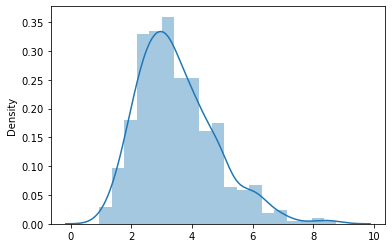

In [ ]:
seaborn.distplot(X)

In [ ]:
tmix.fit(20)

100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


In [ ]:
pyplot.plot(tmix.hist)

In [ ]:
tmix.component_probs+

(500, 51)

/home/mpm289/anaconda3/envs/txmap/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


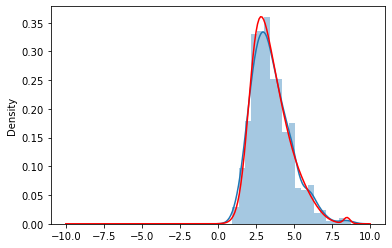

In [ ]:
xdom=numpy.linspace(-10,10,201)
# pyplot.plot(xdom, gendist.pdf(xdom,),c='r')
seaborn.distplot(X)
pyplot.plot(xdom, numpy.exp(tmix.mixture.logpdf(xdom)), c='r')

In [ ]:
#export
class StudentMixtureAccel():
    def __init__(self,X, w=None, logw=None,n_components=20,df=20.):
        self.n_components=n_components
        if isinstance(df, float)==False:
            assert len(df)==self.n_components, f"The array of degrees-of-freedom provide is length {len(df)}. \
            This is not the same length as the number of components {n_components}."
            self.df=df
        else:
            self.df=numpy.ones(self.n_components)*df
        self.X=X
        if isinstance(w, type(None))&isinstance(logw, type(None)):
            self.logw=numpy.zeros(X.shape[0])
        elif isinstance(logw, type(None)):
            self.logw=numpy.log(w)
        else:
            self.logw=logw
            
        self.wt_hist=[]
        self.mu_hist=[]
        self.cov_hist=[]
        self.df_hist=[]
        
        self.hist=[]

    def fit(self, niter):
        X=self.X
        df=self.df
        self.wt_i, self.mu_i, self.cov_i=initialize_by_kmeans(X,self.n_components)
        self.wt_i-=scipy.special.logsumexp(self.wt_i)
        self.wt_hist.append(self.wt_i)
        self.mu_hist.append(self.mu_i)
        self.cov_hist.append(self.cov_i)
        self.df=initialize_df(X, self.logw,self.wt_i,self.df,self. mu_i, self.cov_i)
#         print (self.df)
        self.df_hist.append(self.df)
        self.alpha=[]
        H=self.score()
        self.hist.append(H)
        for iteration in tqdm(range(niter)):
            self.wt_i, self.mu_i, self.cov_i, self.df=update_mixture_Tdist(X, numpy.copy(self.logw) ,
                                                                             numpy.copy(self.wt_i),
                                                                             numpy.copy(self.df),
                                                                             numpy.copy(self.mu_i), numpy.copy(self.cov_i),  )
            self.df[numpy.isnan(self.df)]=4
            self.df[self.df<4]=4
            self.wt_hist.append(self.wt_i)
            self.mu_hist.append(self.mu_i)
            self.cov_hist.append(self.cov_i)
#             self.df_hist.append(self.df)
            for a in numpy.linspace(1,4,11)[::-1]:
                direction=numpy.log(self.df)-numpy.log(self.df_hist[-1])
#                 print (direction)
                new_df=numpy.exp(numpy.log(self.df_hist[-1])+direction*a)
#                 print (new_df)
                mixture=MixtureDistribution(log_wt=self.wt_i, compdists=[scipy.stats.multivariate_t(df=new_df[i],
                                                                                     loc=self.mu_i[i],
                                                                                    shape=self.cov_i[i]) 
                                                          for i in range(len(self.wt_i))])
                Q=self.mixture.logpdf(self.X)
                P=self.logw-numpy.max(self.logw)
#             entropy=numpy.sum(numpy.exp(Q)*(Q-self.logw))
                entropy=numpy.sum(numpy.exp(P)*(P-Q))
                if entropy>=self.hist[-1]:break
            self.alpha.append(a)
#             print (a,numpy.round(new_df), numpy.round(self.df) )
            
            self.df=new_df
            self.df_hist.append(self.df)
        
                                    

            H=self.score()
            self.hist.append(H)
            if numpy.abs((self.hist[-1]-self.hist[-2]))<=1e-4:
                break
#             Q=mixture.logpdf(X)
# #             self.hist.append(scipy.special.logsumexp((Q+self.logw)))
# #             self.hist.append(numpy.sum((Q+self.logw)))
# #             entropy=numpy.sum(numpy.exp(Q)*(Q-self.logw))
#             P=self.logw-numpy.max(self.logw)
# #             entropy=numpy.sum(numpy.exp(Q)*(Q-self.logw))
#             entropy=numpy.sum(numpy.exp(P)*(P-Q))

#             self.hist.append(entropy)
        
    def score(self):
        self.mixture=MixtureDistribution(log_wt=self.wt_i, compdists=[scipy.stats.multivariate_t(df=self.df[i],
                                                                                             loc=self.mu_i[i],
                                                                                            shape=self.cov_i[i]) 
                                                                  for i in range(len(self.wt_i))])
        Q=self.mixture.logpdf(self.X)
# #             self.hist.append(scipy.special.logsumexp((Q+self.logw)))
# #             self.hist.append(numpy.sum((Q+self.logw)))
# #             entropy=numpy.sum(numpy.exp(Q)*(Q-self.logw))
#         P=self.logw-numpy.max(self.logw)
# #             entropy=numpy.sum(numpy.exp(Q)*(Q-self.logw))
#         entropy=numpy.sum(numpy.exp(P)*(P-Q))
        if isinstance(self.target, type(None)):
            P=pi-numpy.max(pi)
            w=P-Q
            entropy=numpy.sum(numpy.exp(P)*(P-Q))
            
            
        else:
            P=self.target
            w=P-Q
            w-=scipy.special.logsumexp(w)
            entropy=numpy.sum(numpy.exp(w)*(w))
#         self.hist.append(entropy)
        return entropy

        

In [ ]:
compdists=[scipy.stats.multivariate_t(loc=numpy.ones(2), shape=numpy.eye(2), df=45),
         scipy.stats.multivariate_t(loc=numpy.ones(2)+3, shape=numpy.eye(2), df=45)]
# target=scipy.stats.multivariate_t(loc=numpy.ones(2), shape=numpy.eye(2), df=25)
target=MixtureDistribution(wt=numpy.array([.5,.5]), compdists=compdists)

data=target.rvs(size=1000)

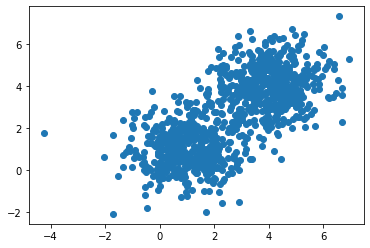

In [ ]:
pyplot.scatter(data[:,0], data[:,1])

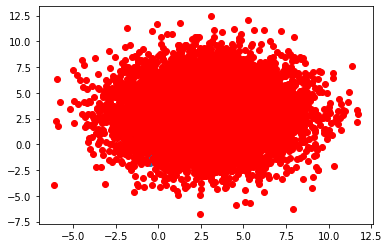

In [ ]:
proposal=scipy.stats.multivariate_normal(mean=numpy.zeros(2)+3, cov=numpy.eye(2)*6, )
Y=proposal.rvs(size=10000)
pyplot.scatter(data[:,0], data[:,1])
pyplot.scatter(Y[:,0], Y[:,1], c='r')

In [ ]:
t_lp=target.logpdf(Y)
p_lp=proposal.logpdf(Y)
logw=t_lp-p_lp
nan_ind=numpy.isnan(logw)
logw=logw[~nan_ind]
logw-=scipy.special.logsumexp(logw)

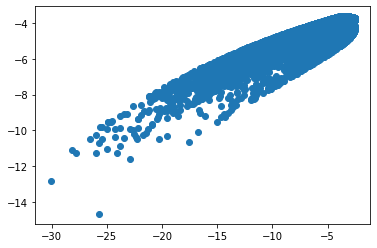

In [ ]:
pyplot.scatter(t_lp,p_lp)

In [ ]:
# MixtureDistribution(l)

In [ ]:
# tmm=StudentMixtureAccel(Y[~nan_ind],logw=logw, n_components=20, df=50.)
tmm=StudentMixture(Y[~nan_ind],logw=logw, n_components=10, df=50.,fix_df=True, target=t_lp)

In [ ]:
tmm.fit(50)

100%|██████████| 50/50 [00:02<00:00, 24.05it/s]


In [ ]:
numpy.exp(scipy.special.logsumexp(tmm.component_probs+(logw[:,None]-logw.max()),0))

array([ 54.28139306, 230.96505724,  94.14426782,  99.33495411,
        19.17932208, 184.90015518, 169.92563176, 222.22872861,
       379.92593721,  65.78208836])

In [ ]:
numpy.exp(logw-logw.max()).sum()

1520.667535423108

In [ ]:
# pyplot.scatter(numpy.arange(len(tmm.alpha)),tmm.alpha)

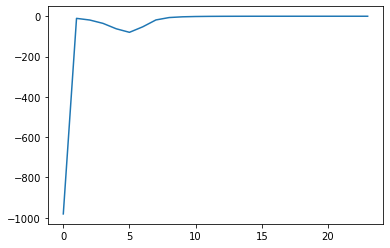

In [ ]:
pyplot.plot(numpy.diff(tmm.hist))
# pyplot.xlim(30,200)
# pyplot.ylim(-.00001,0.001)

In [ ]:
tmm.wt_i

array([-0.68494976, -0.70141236])

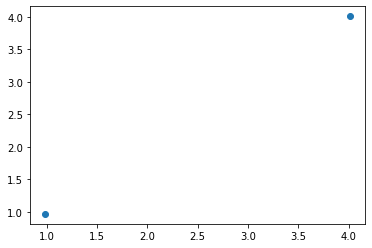

In [ ]:
pyplot.scatter(mu[-1,:,0],mu[-1,:,1])

In [ ]:
df=numpy.array(tmm.df_hist)
# df.shape
df[-1]

array([45.34438069, 45.34438069])

In [ ]:
tmm.df

array([7.87704182, 7.87704182])

In [ ]:
mu=numpy.array(tmm.mu_hist)
mu.shape

(51, 2, 2)

In [ ]:
T=tmm.mixture.rvs(1000)

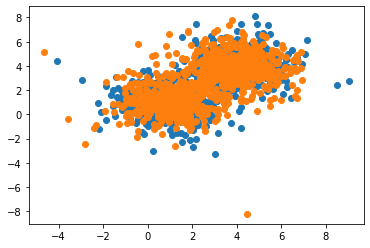

In [ ]:
pyplot.scatter(T[:,0], T[:,1])
pyplot.scatter(data[:,0], data[:,1])

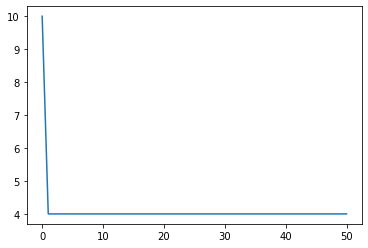

In [ ]:
pyplot.plot(df[:,1])

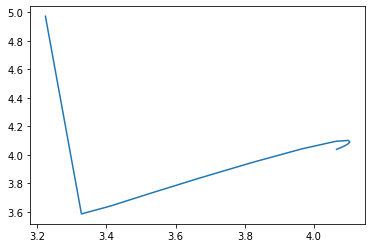

In [ ]:
pyplot.plot(mu[:,0,0],mu[:,0,1])

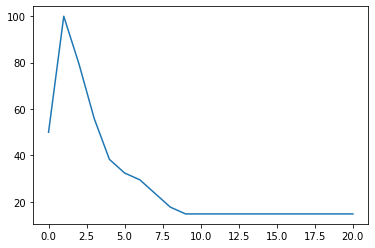

In [ ]:
pyplot.plot(df[:,0])

In [ ]:
#export
def reinitialize_mixture(proposals,W,n_comps=200):
    wt_init=numpy.log(numpy.ones(n_comps)/n_comps)
#     mu_init=proposal.rvs(n_comps)
    mu_ind=numpy.random.choice(numpy.arange(proposals.shape[0]), size=n_comps, replace=False)
#     acc_prob=numpy.exp(W-scipy.special.logsumexp(W))
#     mu_ind=numpy.random.choice(numpy.arange(len(acc_prob)), p=acc_prob, size=n_comps, replace=True)
    mu_init=proposals[mu_ind]
    cov_init=[numpy.eye(mu_init.shape[1])*4 for i in range(n_comps)]
    return wt_init, mu_init, cov_init

In [ ]:
#export
def compute_weighted_mean(x, log_wt):
    wts=numpy.exp(log_wt-scipy.special.logsumexp(log_wt))
    return (x*wts[:,None]).sum(0)
def compute_covariance_regularized( x,mu, log_wt ,cov_reg, gamma=1):
#         mu=self.compute_importance_mean(x, log_wt)
    w=numpy.exp(log_wt-log_wt.max())
#         w=numpy.exp(log_wt-max_wt)

    C=numpy.sum(w)
    Z=x-mu

    full_cov=(cov_reg*gamma+numpy.sum(Z[:,:,None]*Z[:,None,:]*w[:,None,None],0))/(gamma+C)
#         return numpy.diag(numpy.diag(full_cov))
    return full_cov

In [ ]:
#export
def compute_truncated_weights(iw):
    S=float(len(iw))
    mean_iw=scipy.special.logsumexp(iw)-numpy.log(S)
#     print (mean_iw)
    cutoff=mean_iw+numpy.log(S**.5)
#     print (cutoff)
    new_iw=numpy.copy(iw)
    new_iw[iw>cutoff]=cutoff
    new_iw-=scipy.special.logsumexp(new_iw)
#     print ((iw>cutoff).sum())
    return iw

In [ ]:
target=scipy.stats.t(df=2,scale=5)
proposal=scipy.stats.norm(0,1)
phi=proposal.rvs(400)
iw=target.logpdf(phi)-proposal.logpdf(phi)
iw-=scipy.special.logsumexp(iw)

-5.991464547107983
-2.9957322735539917
2


array(0.76155612)

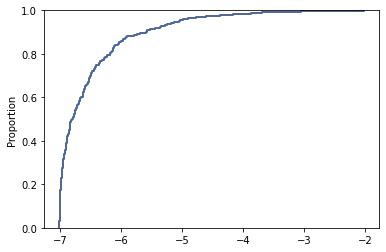

In [ ]:
seaborn.ecdfplot(iw, c='r')
seaborn.ecdfplot(compute_truncated_weights(iw))
psislw(iw)[1]

In [ ]:
# #export
# class tMixtureProposal():
    
#     def __init__(self,
#                  n_components,
#                  df,
#                  reg_wt=4., 
#                  gamma=1.,
#                  rescale=2.,
#                 nsteps=1,
#                 regularization_size=1,
#                 fix_df=False,
#                 use_pareto_smoothing=True):
#         self.n_components=n_components
#         self.regularization_size=regularization_size
#         self.reg_wt=reg_wt
#         self.gamma=gamma
#         self.df=df
#         self.rescale=rescale,
#         self.nsteps=nsteps
#         self.fix_df=fix_df
#         self.use_pareto_smoothing=use_pareto_smoothing
        
#     def fit(self,X, target_logp, proposal_logp,niter, *args, **kwargs ):
#         nsteps=self.nsteps
#         raw_pi=compute_importance_weights(target_logp, proposal_logp)
#         raw_pi=raw_pi-scipy.special.logsumexp(raw_pi)
        
#         sorted_pi=numpy.sort(raw_pi)
# #         regularization_cutoff=numpy.sort(raw_pi)
#         pi=numpy.copy(raw_pi)
# #         pi[pi>=regularization_cutoff]=regularization_cutoff
# #         print (numpy.isnan(pi).sum())
        
#         n_components=self.n_components*niter
#         n_eff=numpy.sum(numpy.exp(pi))
#         # Make sure the number of components isn't greater half the effective sample size
# #         if n_components>n_eff/2:
# #             n_components=numpy.ceil(n_eff/2).astype(int)
# #         if n_components==0: n_components=1
#         if self.use_pareto_smoothing==True:
        
#             psis_pi,k=psislw(pi)
#             if numpy.isnan(psis_pi).sum()>0 or k>.7:
#                 print ('truncating')
#                 psis_pi=compute_truncated_weights(raw_pi)
                
                
#             pi=psis_pi
                
# #             step_count=0
# #             while numpy.isnan(psis_pi).sum()>0 :#or k>.7 :
                
# #                 step_count+=1
# #                 if step_count>8: break
# #                 pi=numpy.copy(raw_pi)
# #                 regularization_cutoff=sorted_pi[-step_count*self.regularization_size]
# #                 pi[pi>=regularization_cutoff]=regularization_cutoff

# #                 psis_pi,k=psislw(pi)
# #             if numpy.isnan(psis_pi).sum()==0:
# #                 pi=psis_pi
# #             else:
# #                 pi=raw_pi
# #             print (step_count)
            
        
            
# #         if k>=.7:
# #             n_eff=numpy.exp(pi-pi.max()).sum()
# #             eff_wt=n_eff/(n_eff+self.reg_wt)
# #             cov_scale=1/eff_wt
# #             mean_phi=compute_weighted_mean(X, pi)
# #             cov_reg=numpy.cov(X.T)
# #             cov_global=compute_covariance_regularized(X, mean_phi,pi, cov_reg/self.rescale, gamma=self.gamma)
# #             global_proposal=scipy.stats.multivariate_t(df=20,mean=mean_phi, cov=cov_global*self.rescale)
# #             return global_proposal
            
            
#         self.tmm=StudentMixture(X,
#                            logw=pi, 
#                            n_components=n_components, 
#                            df=self.df ,
#                         fix_df=self.fix_df,
#                                target=target_logp)
#         self.tmm.fit(niter*nsteps)
#         wt, mu, cov, df=self.tmm.wt_i, self.tmm.mu_i, self.tmm.cov_i, self.tmm.df
#         n_eff=numpy.exp(scipy.special.logsumexp(self.tmm.component_probs+(pi[:,None]-pi.max()),0))   
# #         print (n_eff)
#         eff_wt=n_eff/(n_eff+self.reg_wt)
# #         print (eff_wt)
#         cov_proposal=make_positive_semidef( numpy.cov(X.T))
# #         cov_reg=[cov[i]*eff_wt[i]+(1-eff_wt[i])*cov_proposal/2 for i in range(len(cov))]
        
# #         print (mu_i)

#         #Construct a mixture where each compoment of the TMM is overlaided with a broader distribution
#         # b
#         reg_wt=[]
#         reg_mu=[]
#         reg_df=[]
#         reg_cov=[]
#         for i in range(len(mu)):
#             reg_mu+=[mu[i],mu[i]]
#             reg_cov+=[cov[i],cov_proposal/2]
#             reg_df+=[df[i],df[i]*0+35]
#             reg_wt+=[wt[i]+numpy.log(eff_wt[i]),wt[i]+numpy.log(1-eff_wt[i])]
#         reg_wt=numpy.array(reg_wt)-scipy.special.logsumexp(reg_wt)
            
    
#         local_proposal=MixtureDistribution(log_wt=numpy.array(reg_wt),
#                           compdists=[scipy.stats.multivariate_t(df=reg_df[i],
#                                                                 loc=reg_mu[i], 
#                                                                 shape=make_positive_semidef(2*reg_cov[i])) 
#                                      for i in range(len(reg_mu))])
# #         global_proposal=MixtureDistribution(log_wt=wt,
# #                           compdists=[scipy.stats.multivariate_t(df=df[i],
# #                                                                 loc=mu[i], 
# #                                                                 shape=make_positive_semidef(2*cov_reg[i])) 
#         new_proposal=MixtureDistribution(wt=numpy.array([.5, .5]),
#                                         compdists=[local_proposal,local_proposal])

        
#         return new_proposal
        
        

In [ ]:
#export
class tMixtureProposal():
    
    def __init__(self,
                 n_components,
                 df,
                 reg_wt=4., 
                 gamma=1.,
                 rescale=2.,
                nsteps=1,
                regularization_size=1,
                fix_df=False,
                use_pareto_smoothing=True):
        self.n_components=n_components
        self.regularization_size=regularization_size
        self.reg_wt=reg_wt
        self.gamma=gamma
        self.df=df
        self.rescale=rescale,
        self.nsteps=nsteps
        self.fix_df=fix_df
        self.use_pareto_smoothing=use_pareto_smoothing
        
    def fit(self,X, target_logp, proposal_logp,niter, *args, **kwargs ):
        nsteps=self.nsteps
        raw_pi=compute_importance_weights(target_logp, proposal_logp)
        raw_pi=raw_pi-scipy.special.logsumexp(raw_pi)
        
        sorted_pi=numpy.sort(raw_pi)
#         regularization_cutoff=numpy.sort(raw_pi)
        pi=numpy.copy(raw_pi)
#         pi[pi>=regularization_cutoff]=regularization_cutoff
#         print (numpy.isnan(pi).sum())
        
        n_components=self.n_components*niter
        n_eff=numpy.sum(numpy.exp(pi))
        # Make sure the number of components isn't greater half the effective sample size
#         if n_components>n_eff/2:
#             n_components=numpy.ceil(n_eff/2).astype(int)
#         if n_components==0: n_components=1
        if self.use_pareto_smoothing==True:
        
            psis_pi,k=psislw(pi)
            if numpy.isnan(psis_pi).sum()>0 or k>.7:
                print ('truncating')
                psis_pi=compute_truncated_weights(raw_pi)
                
                
            pi=psis_pi
                
#             step_count=0
#             while numpy.isnan(psis_pi).sum()>0 :#or k>.7 :
                
#                 step_count+=1
#                 if step_count>8: break
#                 pi=numpy.copy(raw_pi)
#                 regularization_cutoff=sorted_pi[-step_count*self.regularization_size]
#                 pi[pi>=regularization_cutoff]=regularization_cutoff

#                 psis_pi,k=psislw(pi)
#             if numpy.isnan(psis_pi).sum()==0:
#                 pi=psis_pi
#             else:
#                 pi=raw_pi
#             print (step_count)
            
        
            
#         if k>=.7:
#             n_eff=numpy.exp(pi-pi.max()).sum()
#             eff_wt=n_eff/(n_eff+self.reg_wt)
#             cov_scale=1/eff_wt
#             mean_phi=compute_weighted_mean(X, pi)
#             cov_reg=numpy.cov(X.T)
#             cov_global=compute_covariance_regularized(X, mean_phi,pi, cov_reg/self.rescale, gamma=self.gamma)
#             global_proposal=scipy.stats.multivariate_t(df=20,mean=mean_phi, cov=cov_global*self.rescale)
#             return global_proposal
            
            
        self.tmm=StudentMixture(X,
                           logw=pi, 
                           n_components=n_components, 
                           df=self.df ,
                        fix_df=self.fix_df,
                               target=target_logp)
        self.tmm.fit(niter*nsteps)
        wt, mu, cov, df=self.tmm.wt_i, self.tmm.mu_i, self.tmm.cov_i, self.tmm.df
        n=numpy.exp(scipy.special.logsumexp(self.tmm.component_probs+(pi[:,None]-pi.max()),0))        
#         print (mu_i)
        local_proposal=MixtureDistribution(log_wt=wt,
                          compdists=[scipy.stats.multivariate_t(df=df[i],loc=mu[i], shape=2*cov[i]) 
                                     for i in range(len(mu))])

        n_eff=numpy.exp(pi-pi.max()).sum()
        eff_wt=n_eff/(n_eff+self.reg_wt)
        print (n_eff)
        cov_scale=1/eff_wt

        mean_phi=compute_weighted_mean(X, pi)
        cov_reg=make_positive_semidef( numpy.cov(X.T))
        try:
            cov_global=make_positive_semidef(compute_covariance_regularized(X,
                                                                            mean_phi,
                                                                            pi,
                                                                            cov_reg/self.rescale, 
                                                                            gamma=self.gamma))
        except:
            cov_global=cov_reg

        global_proposal=MixtureDistribution(log_wt=wt,
                                  compdists=[scipy.stats.multivariate_t(df=df[i]*0+35.,
                                                                        loc=mu[i], 
                                                                        shape=cov_global* self.rescale) 
                                             for i in range(len(mu))])
#         global_proposal=scipy.stats.multivariate_normal(mean=mean_phi, cov=cov_global*self.rescale)
        new_proposal=MixtureDistribution(wt=numpy.array([1-eff_wt, eff_wt]),
                                        compdists=[global_proposal,local_proposal])
#         new_proposal=MixtureDistribution(wt=numpy.array([.5, .5]),
#                                         compdists=[local_proposal,local_proposal])
#         new_proposal=MixtureDistribution(wt=numpy.array([1-eff_wt, eff_wt]),
#                                         compdists=[local_proposal,local_proposal])
        
        return new_proposal
        
        

In [ ]:
numpy.ceil(0.001).astype(int)

1

In [ ]:
# tmprop.tmm.cov_i

In [ ]:
tmprop=tMixtureProposal(10, df=20., nsteps=1)
new_prop=tmprop.fit(Y,t_lp, p_lp, 1)

100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

[205.13959223 154.98557808 216.00265387  82.52661333 104.85873036
 128.00565363 202.55636412  61.51613077 248.71145534 116.36476368]
[0.98087402 0.97484049 0.9818184  0.95377145 0.96325513 0.96969827
 0.98063483 0.93894633 0.98417167 0.96676768]


In [ ]:
new_prop.rvs(1000)

array([[2.2847047 , 1.7056684 ],
       [2.0438144 , 1.04497185],
       [2.41467947, 4.29384747],
       ...,
       [3.86198428, 4.32637451],
       [1.14545628, 2.1406614 ],
       [3.26698483, 1.34077234]])

In [ ]:
new_prop.compdists[0].wt.sahpe

AttributeError: 'numpy.ndarray' object has no attribute 'sahpe'

In [ ]:
# new_prop=tmprop.fit(phi,target_lp, proposal_lp, 1)

In [ ]:
# tphi=new_prop.rvs(1000)

In [ ]:
# pyplot.scatter(tphi[:,0], tphi[:,1])

In [ ]:
# tmm=StudentMixture(phi,logw=pi, n_components=200, df=8.)

In [ ]:
# tmm.fit(11)

In [ ]:
# tmm.mu_i